In [1]:
# 存放文档的目录
documents_directory = 'documents'

# 生成的图片名称
target_svg_file = 'image.svg'
target_jpg_file = 'image.jpg'

In [2]:
%%time

# 抓取目录中的文档

import os

documents = []
for root, dirs, files in os.walk(documents_directory):
    for file in files:
        if file.endswith(".docx") or file.endswith(".doc"):
            documents.append(os.path.join(root, file))

# for file in documents:
#     print(file)


In [3]:
%%time

# 将 word 文档转成 txt，存放在 document.txt 中

import docx
from os import path

def read_txt(filename)->str:
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

txt_documents = []
for doc in documents:
    txt_doc = doc + '.txt'
    txt_documents.append(txt_doc)
    if path.exists(txt_doc):
        continue
    with open(txt_doc, 'w') as txt_file:
        for file in documents:
            txt_file.write(read_txt(file))


In [4]:
%%time

# 中文分词，将一句中文语句中的词语提取出来，放在变量 document_text 中
# 其中 stopwords_path = 'ignore_words.txt' 是忽略的词语，比如 “的”、“所以” 等等没有实际意义的词
# jieba.load_userdict('dict.txt') 和 userdict_list = ['通缩', '通胀', '贬值'] 是两种添加用户自定义词组的方式
# 一般不需要添加，但对于特殊词语，可能分词识别不了。

import jieba

jieba.load_userdict('dict.txt')

userdict_list = ['通缩', '通胀', '贬值', '美联储']

word_cloud_directory = 'word_cloud'

stopwords_path = 'ignore_words.txt'

# The function for processing text with Jieba
def jieba_processing_txt(text):
    for word in userdict_list:
        jieba.add_word(word)

    mywordlist = []
    seg_list = jieba.cut(text, cut_all=False)
    liststr = "/ ".join(seg_list)

    with open(stopwords_path, encoding='utf-8') as f_stop:
        f_stop_text = f_stop.read()
        f_stop_seg_list = f_stop_text.splitlines()

    for myword in liststr.split('/'):
        if not (myword.strip() in f_stop_seg_list) and len(myword.strip()) > 1:
            mywordlist.append(myword)
    return ' '.join(mywordlist)

document_texts = []
for txt_doc in txt_documents:
    jieba_txt = txt_doc + '.jieba'
    if path.exists(jieba_txt):
        with open(jieba_txt, 'r') as f:
            text = f.read()
    else:
        with open (txt_doc, 'r') as f:
            text = f.read()
            text = jieba_processing_txt(text)
            with open(jieba_txt, 'w') as f_jieba:
                f_jieba.write(text)    
    document_texts.append(text)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/y5/kd98q8h54ls52jhthlbldc740000gn/T/jieba.cache
Loading model cost 1.058 seconds.
Prefix dict has been built succesfully.


CPU times: user 990 ms, sys: 97.2 ms, total: 1.09 s
Wall time: 1.3 s


In [5]:
%%time

# 提取标签，根据标签出现的频次
# 其中 

from wordcloud import WordCloud, ImageColorGenerator
from imageio import imread
import matplotlib.pyplot as plt


font_path = word_cloud_directory + '/fonts/SourceHanSerif/SourceHanSerifK-Light.otf'
back_coloring = imread(word_cloud_directory + '/wc_cn/LuXun_color.jpg')

wc = WordCloud(font_path=font_path, background_color="white", max_words=2000, mask=back_coloring,
               max_font_size=200, random_state=42, width=2000, height=2000, margin=2,)

wc.generate(''.join(document_texts))

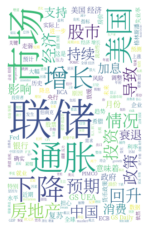

In [6]:
%%time

# create coloring from image
image_colors_default = ImageColorGenerator(back_coloring)

plt.figure()
# recolor wordcloud and show
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

wc.to_file(target_jpg_file)
with open(target_svg_file, 'w') as svg_file:
    svg_file.write(wc.to_svg())
